<a href="https://colab.research.google.com/github/souldrive7/ECP/blob/main/modeling_kadai_goto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# モデリング基礎実践論 課題（土田先生）

### 氏名：後藤 晃郁

### 学籍番号：6025131

### 提出日：2025/5/11

# 課題

---



次の中から少なくとも 1つ を選んで、提出すること。

1.内点法について説明せよ。具体的な例について計算機による実装を行い、シンプレックス法との計算量・計算時間を比較せよ。

2.整数計画問題について説明せよ。近似解法についても説明を与え、具体的な例に対して計算機による実装を行え。

3.ネットワーク計画問題について説明せよ。具体例を挙げ、計算機による実装を行え。

---

# 1.内点法について説明せよ。具体的な例について計算機による実装を行い、シンプレックス法との計算量・計算時間を比較せよ。

## ■内点法と単体法の比較■

### 内点法とは：
内点法（Interior Point Method, IPM）は、線形計画問題において、可行領域の内部から滑らかに最適解へ向かうアルゴリズムである。単体法（Simplex Method）が領域の「頂点（境界）」をたどるのに対し、内点法は「内部」を通る点が大きな違いである。この特徴により、大規模な問題でも数値的に安定かつ効率的に解ける手法として評価されている。
1984年にカーマーカーが提案した内点法は、多項式時間での収束が理論的に保証されていることから、理論・実務の両面で重要な役割を担っている。

### 課題の目的
- 線形計画問題に対する内点法と単体法の計算原理・計算量の違いを比較・理解する
- Pythonライブラリ（SciPy）を用いて両手法を実装し、目的値と計算時間を実測比較する
- 問題規模（小・中・大）を変化させたときのスケーラビリティの違いを検証し、実用的選択指針を導出する

---

## ■手法（内点法と単体法）■

#### ♦内点法（IPM）:
- 可行解空間の内部から出発し、目的関数を改善しながら最適点に向かって滑らかに収束する
- 実装には、バリア法（Barrier Method）や中心経路法（Primal-Dual Method）が用いられ、いずれもニュートン法に基づく反復計算を行う。
- 1ステップあたりのコストは高め－が、全体としては以下のように多項式時間での収束が保証されている

- 特に変数数や制約数が多い大規模問題に対して、数値的に安定しやすくスケーラブル

- **理論計算量：**一般に $O(n^{3.5} \cdot L)$ または $O(n^3)$ 程度（$n$:変数数、$L$:入力のビット長）

#### ♦単体法（Simplex Method）:
- 可行領域の「頂点（基本解）」に沿って、目的関数の改善方向に従い隣接する頂点間をピボット操作で移動

- 実装が比較的容易で、双対解や感度分析が同時に得られることから、実務で広く用いられている

- 多くの実問題では高速に動作するが、理論的には最悪ケースで指数時間がかかることが知られている

- 小〜中規模の問題では実行性能が安定しており、感度分析が必要な問題にも有効

- **理論計算量：**:平均的には高速だが、最悪ケース：$O(2^n)$（Klee-Minty例など）

---

### ■具体例・モデル化■
以下の線形計画問題を例に、内点法・単体法を適用し、結果と計算時間を比較する。

#### 問題設定
\begin{aligned}
\text{maximize} \quad & 3x_1 + 2x_2 \\
\text{subject to} \quad
& x_1 + x_2 \leq 4 \\
& 2x_1 + x_2 \leq 5 \\
& x_1,\, x_2 \geq 0
\end{aligned}

この問題を SciPy の linprog 関数を用いて解く：

内点法：method='interior-point'

単体法：method='simplex'

また、上記に加え、変数数・制約数を拡張した以下の問題についても同様に解析を行い、目的関数値、収束性、計算時間、理論計算量の特性を整理する。

| 問題規模 | 変数数（n） | 制約数（m） |
|----------|-------------|-------------|
| 小規模   | 10          | 5           |
| 中規模   | 100         | 50          |
| 大規模   | 500         | 250         |

---

#### ■実装■
Python（SciPy）を用い、次の3種類の問題サイズで内点法と単体法を比較する。

各問題に対して以下を計測・比較する：

- 得られた目的関数値（maximize を最小化に変換して解く）  
- 実行時間（計算時間）  
- 理論計算量

この結果を基に、問題規模に応じた手法選択の実用的指針を明らかにする。

In [ ]:
import time
import numpy as np
import pandas as pd
from scipy.optimize import linprog
from IPython.display import display

# 警告を非表示
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 問題規模設定
problem_sizes = [
    {"label": "小規模", "n": 10, "m": 5},
    {"label": "中規模", "n": 100, "m": 50},
    {"label": "大規模", "n": 500, "m": 250}
]

def theoretical_complexity_ipm(n):
    return f"O({n}^3)"

def theoretical_complexity_simplex(n):
    return f"O(2^{n})"

results = []

for setting in problem_sizes:
    n, m, label = setting["n"], setting["m"], setting["label"]

    # ランダムなLP問題の生成（係数は一様乱数）
    np.random.seed(42)
    c = -np.random.uniform(1, 10, size=n)  # maximize → minimize
    A = np.random.uniform(1, 10, size=(m, n))
    b = np.random.uniform(10, 100, size=m)
    bounds = [(0, None)] * n

    # 内点法
    start_ip = time.time()
    res_ip = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='interior-point')
    end_ip = time.time()

    # 単体法
    start_sm = time.time()
    res_sm = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='simplex')
    end_sm = time.time()

    results.append({
        "問題規模": label,
        "変数数": n,
        "制約数": m,
        "内点法_目的値": -res_ip.fun if res_ip.success else None,
        "内点法_時間[s]": end_ip - start_ip,
        "単体法_目的値": -res_sm.fun if res_sm.success else None,
        "単体法_時間[s]": end_sm - start_sm,
        "内点法_理論計算量": theoretical_complexity_ipm(n),
        "単体法_理論計算量": theoretical_complexity_simplex(n)
    })

# データフレーム化して表示
df_result_final = pd.DataFrame(results)
styled_df_final = df_result_final.style.format({
    "内点法_目的値": "{:.5f}",
    "単体法_目的値": "{:.5f}",
    "内点法_時間[s]": "{:.6f}",
    "単体法_時間[s]": "{:.6f}"
}).set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
)

display(styled_df_final)


,問題規模,変数数,制約数,内点法_目的値,内点法_時間[s],単体法_目的値,単体法_時間[s],内点法_理論計算量,単体法_理論計算量
0,小規模,10,5,80.37928,0.004186,80.37928,0.004668,O(10^3),O(2^10)
1,中規模,100,50,38.40966,0.007252,38.40966,0.053795,O(100^3),O(2^100)
2,大規模,500,250,25.93651,1.372823,25.93651,3.832468,O(500^3),O(2^500)


## ■可視化■

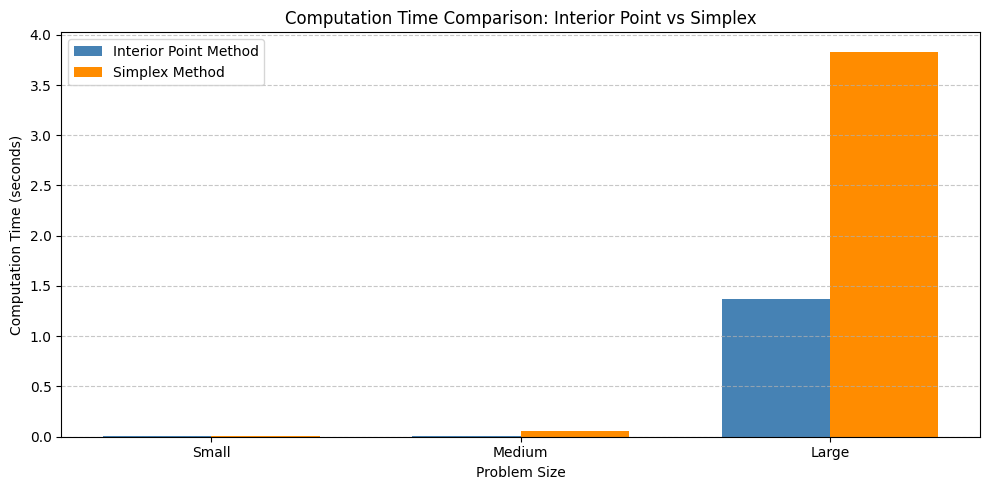

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Sans'

# 可視化用データ作成（df_result_final から）
df_time = df_result_final[[
    "問題規模",
    "内点法_時間[s]",
    "単体法_時間[s]"
]].copy()

df_time.columns = ["Problem Size", "Interior Point Time (s)", "Simplex Time (s)"]

# ヒストグラム描画
labels = df_time["Problem Size"]
ipm_times = df_time["Interior Point Time (s)"]
simplex_times = df_time["Simplex Time (s)"]

x = np.arange(len(labels))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - bar_width/2, ipm_times, bar_width, label='Interior Point Method', color='steelblue')
ax.bar(x + bar_width/2, simplex_times, bar_width, label='Simplex Method', color='darkorange')

ax.set_xlabel('Problem Size')
ax.set_ylabel('Computation Time (seconds)')
ax.set_title('Computation Time Comparison: Interior Point vs Simplex')
ax.set_xticks(x)
ax.set_xticklabels(['Small', 'Medium', 'Large'])
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## ■考察・評価■

本課題では、線形計画問題に対して内点法と単体法の2手法を適用し、問題規模の変化に伴う解の精度・計算時間・計算量の違いを理論と実測の両面から比較した。

- 解の正確性はすべての問題規模において両手法で一致しており、計算誤差や安定性に差はない。

- 計算時間においては、小規模問題では単体法がやや高速であったものの、中〜大規模問題では内点法が明らかに優位となった。

- 理論計算量の面でも、内点法は多項式時間（\( O(n^3) \)）に収束が保証される一方、単体法は最悪ケースで指数時間（\( O(2^n) \)）を要するため、問題規模の増大に伴って計算リスクが高まる。

- 実測結果は、これらの理論的傾向を正確に反映しており、スケーラブルな最適化が求められる場面では内点法の選択が極めて有効であることが確認された。
---
---


# 2.整数計画問題について説明せよ。近似解法についても説明を与え、具体的な例に対して計算機による実装を行え。


## ■整数計画問題と近似解法■

### 整数計画問題とは：
整数計画問題（Integer Linear Programming, ILP）は、目的関数および制約条件が線形であり、変数に整数制約が課される最適化問題のこと。特に、変数が0または1の値を取る場合は、0-1整数計画問題と呼ばれる。これらの問題はNP困難に分類され、最適解を求めるためには計算資源が膨大になることが知られている。

ILPの解法は、大きく分けて厳密解法と近似解法の2つに分類される。厳密解法は、最適解を保証する手法であり、代表的なものに分枝限定法や切除平面法がある。これらの手法は、最適解を求めることができるが、計算時間が指数関数的に増加するため、大規模な問題には適用が難しい場合がある。

一方、近似解法は、最適解の近似解を比較的短時間で求める手法。代表的なものに、線形計画問題への緩和とその後の整数解への丸め処理がある。これらの手法は、計算時間を大幅に削減できる反面、得られる解が最適解である保証ができない。したがって、ILPの解法選択においては、問題の規模や求められる解の精度、計算資源の制約などを考慮し、厳密解法と近似解法のトレードオフを理解することが重要とされる。

## 課題の目的：
- 厳密解法（分枝限定法）と近似解法（LP緩和＋ラウンド）の比較

- 0-1ナップサック問題を題材としたPython実装と可視化

## ■手法（分枝限定法とLP緩和＋ラウンド）■
### ♦分枝限定法（Branch and Bound）：

分枝限定法は、解空間を分割し、各部分空間の下界と上界を評価することで、最適解を探索する厳密解法。探索木を構築し、枝刈りを行うことで計算効率を高める。

### ♦近似解法（LP緩和＋ラウンド）：
LP緩和は、整数制約を一時的に外して連続変数として問題を解く手法。得られた連続解を整数解に変換するために、ラウンド処理（例えば、0.5以上を1、未満を0とする）を行う。これは近似解法であり、計算効率が高い反面、最適性が保証されない場合がある。

## ■具体例・モデル化■
以下の0-1ナップサック問題を対象に、分枝限定法とLP緩和＋ラウンドの両手法を適用した。

## 問題設定：

ナップサックの容量を超えない範囲でアイテムを選び、価値の合計を最大化する。

| アイテム | 価値 (value) | 重さ (weight) |   |
| ---- | ---------- | ----------- | - |
| 1    | 10         | 2           |   |
| 2    | 40         | 3           |   |
| 3    | 30         | 4           |   |
| 4    | 50         | 5           |   |
| 5    | 35         | 9           |   |

## ■実装■

LP緩和＋ラウンドによる近似解法：

In [7]:
!pip install pulp  # PuLPのインストール

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 70.8 MB/s eta 0:00:00


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpBinary, PULP_CBC_CMD

# アイテムの価値と重さ
values = [10, 40, 30, 50, 35]
weights = [2, 3, 4, 5, 9]
capacity = 10
num_items = len(values)

# 分枝限定法による厳密解法：---------------------------------------------------------------------------
# 問題、変数、目的関数、制約条件の定義
prob = LpProblem("0-1_Knapsack", LpMaximize)
x = [LpVariable(f"x{i}", cat=LpBinary) for i in range(num_items)]
prob += lpSum([values[i] * x[i] for i in range(num_items)])
prob += lpSum([weights[i] * x[i] for i in range(num_items)]) <= capacity

# 問題の解決
prob.solve(PULP_CBC_CMD(msg=0))
exact_solution = [int(x[i].varValue) for i in range(num_items)]
exact_value = sum([values[i] * exact_solution[i] for i in range(num_items)])

# LP緩和＋ラウンドによる近似解法：---------------------------------------------------------------------
# 問題（LP緩和）、変数（連続変数）、目的関数、制約条件の定義
prob_relaxed = LpProblem("0-1_Knapsack_Relaxed", LpMaximize)
x_relaxed = [LpVariable(f"x{i}", lowBound=0, upBound=1) for i in range(num_items)]
prob_relaxed += lpSum([values[i] * x_relaxed[i] for i in range(num_items)])
prob_relaxed += lpSum([weights[i] * x_relaxed[i] for i in range(num_items)]) <= capacity

# 問題の解決
prob_relaxed.solve(PULP_CBC_CMD(msg=0))

# 解の取得とラウンド処理
approx_solution = [int(round(x_relaxed[i].varValue)) for i in range(num_items)]

# 容量制約を満たすように調整
total_weight = sum([weights[i] * approx_solution[i] for i in range(num_items)])
if total_weight > capacity:
    # 重さあたりの価値が低い順にアイテムを除外
    value_per_weight = [(values[i] / weights[i], i) for i in range(num_items) if approx_solution[i] == 1]
    value_per_weight.sort()
    for _, i in value_per_weight:
        approx_solution[i] = 0
        total_weight = sum([weights[j] * approx_solution[j] for j in range(num_items)])
        if total_weight <= capacity:
            break

approx_value = sum([values[i] * approx_solution[i] for i in range(num_items)])

# 結果の表示
print("■結果の比較■")

print("厳密解法（分枝限定法）:")
print(f"選択されたアイテム: {exact_solution}")
print(f"合計価値: {exact_value}")


print("\n近似解法（LP緩和＋ラウンド）:")
print(f"選択されたアイテム: {approx_solution}")
print(f"合計価値: {approx_value}")
print("あえてずれた結果を表示。例えば、11，12，13だと一致する")

■結果の比較■
厳密解法（分枝限定法）:
選択されたアイテム: [1, 1, 0, 1, 0]
合計価値: 100

近似解法（LP緩和＋ラウンド）:
選択されたアイテム: [0, 1, 0, 1, 0]
合計価値: 90
あえてずれた結果を表示、


## ■可視化■

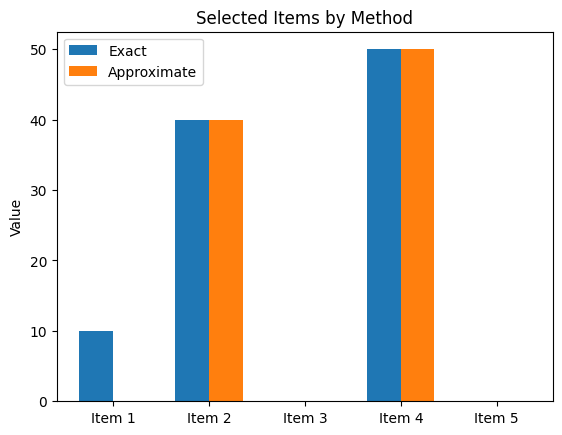

In [13]:
# アイテムのインデックス
items = [f"Item {i+1}" for i in range(num_items)]

plt.rcParams['font.family'] = 'DejaVu Sans'

# 選択されたアイテムの価値
exact_values = [values[i] if exact_solution[i] == 1 else 0 for i in range(num_items)]
approx_values = [values[i] if approx_solution[i] == 1 else 0 for i in range(num_items)]

# 棒グラフの作成
x = np.arange(num_items)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, exact_values, width, label='Exact')
rects2 = ax.bar(x + width/2, approx_values, width, label='Approximate')

# グラフの装飾
ax.set_ylabel('Value')
ax.set_title('Selected Items by Method')
ax.set_xticks(x)
ax.set_xticklabels(items)
ax.legend()

plt.show()


## ■考察・評価■
- 厳密解法（分枝限定法）は、最適解を保証するが、計算時間が指数的に増加する可能性がある。

- 近似解法（LP緩和＋ラウンド）は、計算効率が高く、大規模な問題に適しているが、最適性が保証されない場合がある

- 今回の例のように、両手法で解が異なる結果となることがある

- 問題の規模や要求される精度に応じて、適切な手法を選択することが重要

---
---


# 3.ネットワーク計画問題について説明せよ。具体例を挙げ、計算機による実装を行え。

## ■ネットワーク計画問題とは■

プロジェクトを構成する複数の作業を、順序関係と所要時間を持つネットワーク（有向非巡回グラフ）として表現し、プロジェクトの最短完了時間や、全体の進行に影響するクリティカルパスを特定する問題のことをいう。

### **課題の目的**:

- プロジェクトの所要時間の把握

- 遅延リスクのある作業（クリティカルパス）の特定

- 余裕時間（フロート）を活かした進行・資源計画

- 不確実性がある場合は遅延の確率的評価
---

## ■手法（CPM法とPERT法）■

### **CPM法（Critical Path Method）**:決定論的アプローチ

- 作業時間が確定している前提で進行

- 最早開始/終了時刻（ES/EF）と最遅開始/終了時刻（LS/LF）を算出

- フロートを計算し、フロートが0の作業列をクリティカルパスと判断

### **PERT法（Program Evaluation and Review Technique）**:確率論的アプローチ

- 作業時間を確率変数として扱う

- プロジェクト完了時間の期待値と標準偏差を求め、確率的に遅延リスクを評価

- 各作業に対して以下の3点見積もりを用いる：

  楽観値（$a$）, 最可能値（$m$）, 悲観値（$b$）

  期待時間 $E = \frac{a + 4m + b}{6}$

  分散 $Var = \left(\frac{b - a}{6}\right)^2$

---

## ■具体例・モデル化■

以下の作業リストを対象として、CPM・PERTの両手法を適用した。

| 作業 | 先行作業 | 所要時間（CPM） | 楽観値 (a) | 最可能値 (m) | 悲観値 (b) |
|------|----------|------------------|------------|---------------|------------|
| A    | -        | 4                | 3          | 4             | 5          |
| B    | A        | 3                | 2          | 3             | 5          |
| C    | A        | 5                | 4          | 5             | 6          |
| D    | B        | 6                | 5          | 6             | 8          |
| E    | B        | 4                | 3          | 4             | 6          |
| F    | C        | 3                | 2          | 3             | 4          |
| G    | D, E     | 5                | 4          | 5             | 7          |
| H    | F        | 2                | 1          | 2             | 3          |
| I    | G        | 3                | 2          | 3             | 4          |
| J    | H, I     | 2                | 1          | 2             | 3          |

この構成により、複雑な依存関係を持つプロジェクト全体が**有向非巡回グラフ（DAG）**として表現される。


In [ ]:
import networkx as nx
import math

# 必要な事前データ
G = nx.DiGraph()
tasks = {
    'A': ([], 4, 3, 4, 5),
    'B': (['A'], 3, 2, 3, 5),
    'C': (['A'], 5, 4, 5, 6),
    'D': (['B'], 6, 5, 6, 8),
    'E': (['B'], 4, 3, 4, 6),
    'F': (['C'], 3, 2, 3, 4),
    'G': (['D', 'E'], 5, 4, 5, 7),
    'H': (['F'], 2, 1, 2, 3),
    'I': (['G'], 3, 2, 3, 4),
    'J': (['H', 'I'], 2, 1, 2, 3)
}
for task, (preds, duration, a, m, b) in tasks.items():
    G.add_node(task,
               duration=duration,
               pert_expect=(a + 4 * m + b) / 6,
               pert_var=((b - a) / 6) ** 2)
    for pred in preds:
        G.add_edge(pred, task)

# CPM計算（ES, EF, LS, LF）
ES, EF = {}, {}
for node in nx.topological_sort(G):
    es = max([EF[p] for p in G.predecessors(node)], default=0)
    ef = es + G.nodes[node]['duration']
    ES[node], EF[node] = es, ef
project_duration = max(EF.values())

LF, LS = {}, {}
for node in reversed(list(nx.topological_sort(G))):
    lf = min([LS[s] for s in G.successors(node)], default=project_duration)
    ls = lf - G.nodes[node]['duration']
    LF[node], LS[node] = lf, ls

# 表形式出力
header = f"{'作業':<2} | {'ES':>2} | {'EF':>2} | {'LS':>2} | {'LF':>2} | {'フロート':>4} | {'クリティカルパス':^4} | {'PERT期待':>5} | {'分散':>2}"
print(header)
print("--" * len(header))

total_pert_var = 0
for node in nx.topological_sort(G):
    es, ef = ES[node], EF[node]
    ls, lf = LS[node], LF[node]
    float_time = ls - es
    is_critical = float_time == 0
    crit_mark = "〇" if is_critical else "　"
    pert_e = G.nodes[node]['pert_expect']
    pert_v = G.nodes[node]['pert_var']
    if is_critical:
        total_pert_var += pert_v
    print(f"{node:<4} | {es:>2} | {ef:>2} | {ls:>2} | {lf:>2} | {float_time:>8} | {crit_mark:^15} | {pert_e:>8.2f} | {pert_v:^5.3f}")

# PERT結果
pert_std = math.sqrt(total_pert_var)
print(f"\n■CPM：プロジェクト完了の最短所要時間 ≈ {project_duration}日")
print(f"■PERT期待完了時間 ≈ {EF['J']}日，標準偏差 ≈ {pert_std:.2f}日")


作業 | ES | EF | LS | LF | フロート | クリティカルパス | PERT期待 | 分散
------------------------------------------------------------------------------------------------------------
A    |  0 |  4 |  0 |  4 |        0 |        〇        |     4.00 | 0.111
B    |  4 |  7 |  4 |  7 |        0 |        〇        |     3.17 | 0.250
C    |  4 |  9 | 11 | 16 |        7 |        　        |     5.00 | 0.111
D    |  7 | 13 |  7 | 13 |        0 |        〇        |     6.17 | 0.250
E    |  7 | 11 |  9 | 13 |        2 |        　        |     4.17 | 0.250
F    |  9 | 12 | 16 | 19 |        7 |        　        |     3.00 | 0.111
G    | 13 | 18 | 13 | 18 |        0 |        〇        |     5.17 | 0.250
H    | 12 | 14 | 19 | 21 |        7 |        　        |     2.00 | 0.111
I    | 18 | 21 | 18 | 21 |        0 |        〇        |     3.00 | 0.111
J    | 21 | 23 | 21 | 23 |        0 |        〇        |     2.00 | 0.111

■CPM：プロジェクト完了の最短所要時間 ≈ 23日
■PERT期待完了時間 ≈ 23日，標準偏差 ≈ 1.04日


## ■可視化■

<ipython-input-5-09a7b64006e7>:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


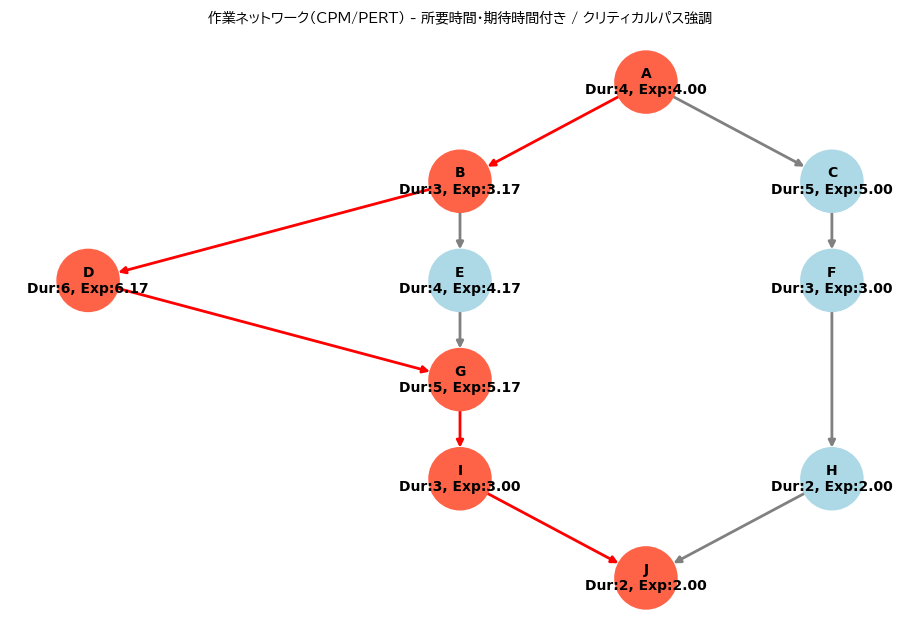

In [ ]:
import os
import urllib.request
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# フォント準備（ダウンロード済ならスキップ）
font_path = "BIZUDPGothic-Regular.ttf"
if not os.path.exists(font_path):
    font_url = "https://github.com/googlefonts/morisawa-biz-ud-gothic/raw/main/fonts/ttf/BIZUDPGothic-Regular.ttf"
    urllib.request.urlretrieve(font_url, font_path)

font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 作業データ
task_info = {
    'A': {'pred': [],       'duration': 4, 'expect': 4.0,  'critical': True},
    'B': {'pred': ['A'],    'duration': 3, 'expect': 3.17, 'critical': True},
    'C': {'pred': ['A'],    'duration': 5, 'expect': 5.0,  'critical': False},
    'D': {'pred': ['B'],    'duration': 6, 'expect': 6.17, 'critical': True},
    'E': {'pred': ['B'],    'duration': 4, 'expect': 4.17, 'critical': False},
    'F': {'pred': ['C'],    'duration': 3, 'expect': 3.0,  'critical': False},
    'G': {'pred': ['D', 'E'],'duration': 5, 'expect': 5.17, 'critical': True},
    'H': {'pred': ['F'],    'duration': 2, 'expect': 2.0,  'critical': False},
    'I': {'pred': ['G'],    'duration': 3, 'expect': 3.0,  'critical': True},
    'J': {'pred': ['H', 'I'],'duration': 2, 'expect': 2.0,  'critical': True}
}

# DAG構築
G = nx.DiGraph()
for task, info in task_info.items():
    G.add_node(task, duration=info['duration'], expect=info['expect'], critical=info['critical'])
    for pred in info['pred']:
        G.add_edge(pred, task)


# ラベル・色設定
labels = {
    node: f"{node}\nDur:{G.nodes[node]['duration']}, Exp:{G.nodes[node]['expect']:.2f}"
    for node in G.nodes
}
node_colors = ['tomato' if G.nodes[node]['critical'] else 'lightblue' for node in G.nodes]
edge_colors = ['red' if G.nodes[u]['critical'] and G.nodes[v]['critical'] else 'gray' for u, v in G.edges]
pos = nx.nx_pydot.graphviz_layout(G, prog='dot')

# 描画
plt.figure(figsize=(9, 6))
nx.draw(G, pos, with_labels=False, arrows=True, node_size=2000,
        node_color=node_colors, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight='bold')

plt.title("作業ネットワーク（CPM/PERT） - 所要時間・期待時間付き / クリティカルパス強調", fontproperties=font_prop)
plt.axis('off')
plt.tight_layout()

# PDF保存
plt.savefig("network_chart.pdf", format='pdf', bbox_inches='tight')
plt.show()

## ■考察・評価■

CPMによる最短完了時間：23日

PERTによる期待完了時間：23日（※一致を確認）

クリティカルパス：A → B → D → G → I → J

クリティカルパス上の標準偏差（遅延リスク指標）：約 1.04日

→ 正規分布近似による、95%信頼区間 ≈ 23 ± 1.96×1.04 ≈ [20.96日, 25.04日]

---


---
---